<a href="https://colab.research.google.com/github/dkanh6/Machine_Learning_Examples/blob/main/Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First I am going to get the data into this python notebook

In [60]:
from google.colab import files
uploaded = files.upload()

import h5py
import numpy as np

# Initialize data structures for LFP recordings and segment counts
lfp = {'NREM': [], 'WAKE': []}
segment_counts = {'NREM': 0, 'WAKE': 0}

# Loop over each uploaded file
for filename in uploaded.keys():
    print(f'Processing file "{filename}" with length {len(uploaded[filename])} bytes')
    with h5py.File(filename, 'r') as f:  # Open the file
        # Assuming 'fs' is a global attribute for sampling frequency
        fs = f.attrs['fs'][0]
        print(f"Sampling rate: {fs:.1f} Hz")

        # Loop over states in each file
        for state in f.keys():
            group = f[state]  # Access the group corresponding to the state
            segment_ids = list(group.keys())  # List segment IDs within the state

            # Update the count of segments for the state
            segment_counts[state] += len(segment_ids)

            # Extract and store segment data from each file
            for segment_id in segment_ids:
                segment_data = np.array(group[segment_id]).astype(float)
                lfp[state].append(segment_data)

# Print the total number of segments for each state
for state, count in segment_counts.items():
    print(f"Total segments for state '{state}': {count}")


Saving Rat08-20130711_017.h5 to Rat08-20130711_017 (2).h5
Processing file "Rat08-20130711_017 (2).h5" with length 46559900 bytes
Sampling rate: 1250.0 Hz
Total segments for state 'NREM': 59
Total segments for state 'WAKE': 37


Now I am going to quickly extract and visualize the data
I am going to extract segments within each state and visualize some of the segments so I can use them as training data.

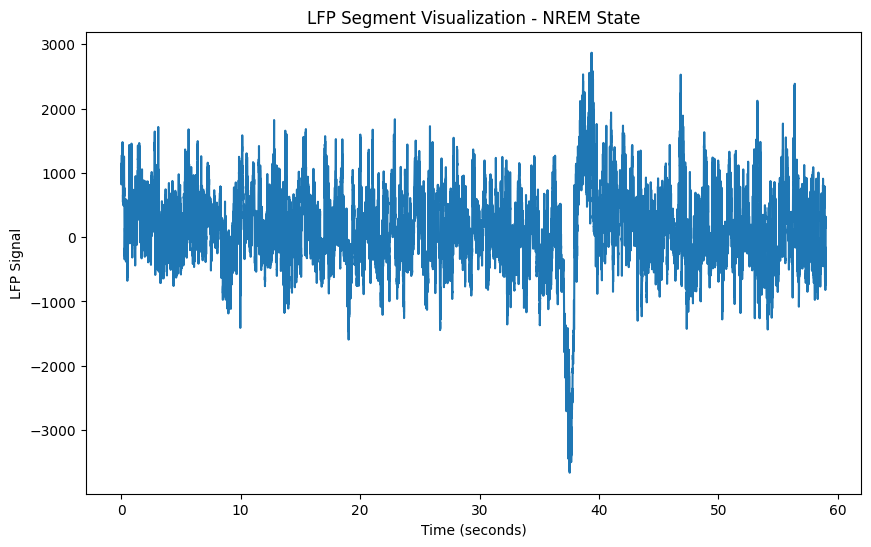

In [61]:
import matplotlib.pyplot as plt

state = 'NREM'  # The state you're interested in
segment_index = 2  # The segment index you want to visualize

# Check if the state and segment index are valid
if state in lfp and segment_index < segment_counts[state]:
    x = lfp[state][segment_index]
    t = np.arange(len(x)) / fs  # Time axis

    plt.figure(figsize=(10, 6))
    plt.plot(t, x)
    plt.xlabel('Time (seconds)')
    plt.ylabel('LFP Signal')
    plt.title(f'LFP Segment Visualization - {state} State')
    plt.show()
else:
    print(f"Data for state '{state}' with index {segment_index} is not available.")

In [62]:
# Ensure sampling_rate and clip_duration are defined correctly
sampling_rate = int(fs)  # Convert to integer if not already
clip_duration = 5  # Duration in seconds

# Calculate samples per clip and explicitly convert to integer
samples_per_clip = int(clip_duration * sampling_rate)

# Now, use this corrected `samples_per_clip` in your loop
clips = {state: [] for state in states}

for state in states:
    for segment in lfp[state]:
        num_clips = len(segment) // samples_per_clip

        for i in range(num_clips):
            start_sample = i * samples_per_clip
            end_sample = start_sample + samples_per_clip
            clip = segment[start_sample:end_sample]
            clips[state].append(clip)
        # ignoring partial clips that are not 5 seconds. opting to not pad them with zeros and use them for training
for state in clips:
    num_clips = len(clips[state])
    print(f"State: {state}, Number of 5-second clips: {num_clips}")


State: NREM, Number of 5-second clips: 1239
State: WAKE, Number of 5-second clips: 2443


Next I need to extract some various features that I can feed into the network

In [63]:
from scipy.stats import skew, kurtosis

# Initialize a dictionary to hold the clip data along with their computed features for each state
clip_features = {'NREM': [], 'WAKE': []}

for state in clips:
    for clip in clips[state]:
        # Calculate various statistics for the current clip
        clip_mean = np.mean(clip)
        clip_std = np.std(clip)
        clip_skewness = skew(clip)
        clip_kurtosis = kurtosis(clip)
        #clip_entropy = entropy(np.histogram(clip, bins=10)[0])

        # Append the clip and its computed features as a dictionary to the state's list
        clip_features[state].append({
            'clip': clip,
            'mean': clip_mean,
            'std': clip_std,
            'skewness': clip_skewness,
            'kurtosis': clip_kurtosis,
            #'entropy': clip_entropy
        })

# Accessing and displaying the features of the first clip for 'NREM' state
first_nrem_clip_features = clip_features['NREM'][0]
print("Features of the first 'NREM' clip:")
print(f"Mean: {first_nrem_clip_features['mean']}")
print(f"STD: {first_nrem_clip_features['std']}")
print(f"Skewness: {first_nrem_clip_features['skewness']}")
print(f"Kurtosis: {first_nrem_clip_features['kurtosis']}")

# If original signa still needed:
example_clip = first_nrem_clip_features['clip']


Features of the first 'NREM' clip:
Mean: 34.792
STD: 698.1702320322745
Skewness: 0.21606066352768008
Kurtosis: -0.48215938742358544


Now, I am going to do some PSD calculations using a small portion of the clip (maybe 1/5th of the total clip length)


In [64]:
from scipy.signal import welch

# Initialize a new key in the dictionary for PSD
for state in clip_features:
    for clip_feature in clip_features[state]:
        clip = clip_feature['clip']

        # Choose nperseg as a fraction of the clip length for lower frequency resolution
        # Example: Using 1/4th of the clip length
        nperseg = len(clip) // 4

        # Calculate the PSD using Welch's method
        frequencies, psd = welch(clip, fs=sampling_rate, nperseg=nperseg)

        # Store the PSD data in the clip's feature dictionary
        clip_feature['psd'] = psd
        clip_feature['frequencies'] = frequencies

# Example: Accessing the PSD of the first clip for 'NREM' state
first_nrem_clip_features = clip_features['NREM'][0]
print("PSD of the first 'NREM' clip (first 10 values):")
print(first_nrem_clip_features['psd'][:10])
print("Frequencies of the first 'NREM' clip (first 10 values):")
print(first_nrem_clip_features['frequencies'][:10])

PSD of the first 'NREM' clip (first 10 values):
[18944.92492392 62178.9975459  26733.93324896 13842.76485718
  6711.64877445  3410.03794675  5303.35886803  6408.1468584
  8138.92701462  4932.13993321]
Frequencies of the first 'NREM' clip (first 10 values):
[0.         0.80025608 1.60051216 2.40076825 3.20102433 4.00128041
 4.80153649 5.60179257 6.40204866 7.20230474]


Now to find oscillation frequency bands in the PSD of each state to identify where the largest frequency band and use it as a feature

In [65]:
from scipy.signal import butter, sosfilt, sosfreqz

# Function to create a bandpass filter and apply it
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    filtered = sosfilt(sos, data)
    return filtered

# Identify your bands here based on the overall PSD analysis
# Example: Assuming you found a significant band from 5 to 12 Hz
bands = {
    'theta': (5, 12),
}

# Apply bandpass filtering and calculate statistics for each clip in each state
for state in clip_features:
    for clip_feature in clip_features[state]:
        clip = clip_feature['clip']
        for band_name, (lowcut, highcut) in bands.items():
            # Filter the clip for the current band
            filtered_clip = bandpass_filter(clip, lowcut, highcut, fs=sampling_rate)

            # Calculate statistics on the filtered signal
            mean_power = np.mean(filtered_clip ** 2)
            std_power = np.std(filtered_clip ** 2)

            # Store the statistics in the clip's feature dictionary
            if 'band_stats' not in clip_feature:
                clip_feature['band_stats'] = {}
            clip_feature['band_stats'][band_name] = {'mean_power': mean_power, 'std_power': std_power}

# Example: Display the band-specific stats for the first NREM clip
first_nrem_clip_features = clip_features['NREM'][0]
print("Band-specific stats for the first 'NREM' clip:")
print(first_nrem_clip_features['band_stats'])


Band-specific stats for the first 'NREM' clip:
{'theta': {'mean_power': 40079.14433176896, 'std_power': 56804.77614687043}}


Now to normalize the features

In [66]:
from scipy.stats import zscore

# First, flatten features values to apply normalization
mean_powers = [clip_feature['band_stats']['theta']['mean_power'] for state in clip_features for clip_feature in clip_features[state]]

# Apply Z-score normalization
mean_powers_normalized = zscore(mean_powers)

# Update original data structure with normalized values
i = 0  # Initialize a counter to track the current index in normalized values
for state in clip_features:
    for clip_feature in clip_features[state]:
        clip_feature['band_stats']['theta']['mean_power_normalized'] = mean_powers_normalized[i]
        i += 1


Now separate into training, testing, and cross validation

In [67]:
from sklearn.model_selection import train_test_split

# Example ratios
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

# Prepare features and labels
features = []
labels = []  # Assuming 0 for NREM and 1 for WAKE

for state in clip_features:
    for clip_feature in clip_features[state]:
        # Assuming mean_power_normalized and std_power as the features for simplicity
        mean_power_normalized = clip_feature['band_stats']['theta']['mean_power_normalized']
        std_power = clip_feature['band_stats']['theta']['std_power']

        # Create a feature vector for each clip
        feature_vector = [mean_power_normalized, std_power]
        features.append(feature_vector)

        # Append the label
        label = 0 if state == 'NREM' else 1
        labels.append(label)

# Convert to NumPy arrays for easier manipulation
features = np.array(features)
labels = np.array(labels)

# Splitting the dataset into training, validation, and testing sets
# First, split into training and temporary sets (temp will be further split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, train_size=train_ratio, random_state=42)

# Calculate the split ratio for validation
validation_size = validation_ratio / (validation_ratio + test_ratio)

# Now split the temporary set into validation and test sets
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=validation_size, random_state=42)



Now that i have my data processed into features and separated into test, train, and cross validation the actual traning needs to be done using pytorch.

Epoch 1/50, Train Loss: 280.2540, Validation Loss: 40.2574, Train Accuracy: 55.18%, Validation Accuracy: 66.71%
Epoch 2/50, Train Loss: 81.4590, Validation Loss: 6.6214, Train Accuracy: 57.45%, Validation Accuracy: 66.71%
Epoch 3/50, Train Loss: 54.0101, Validation Loss: 10.8734, Train Accuracy: 53.15%, Validation Accuracy: 66.71%
Epoch 4/50, Train Loss: 26.9869, Validation Loss: 1.0314, Train Accuracy: 53.64%, Validation Accuracy: 33.29%
Epoch 5/50, Train Loss: 21.9360, Validation Loss: 9.3000, Train Accuracy: 55.32%, Validation Accuracy: 33.29%
Epoch 6/50, Train Loss: 12.1318, Validation Loss: 3.4538, Train Accuracy: 54.50%, Validation Accuracy: 66.71%
Epoch 7/50, Train Loss: 10.6393, Validation Loss: 1.5314, Train Accuracy: 54.23%, Validation Accuracy: 66.71%
Epoch 8/50, Train Loss: 5.5847, Validation Loss: 0.6950, Train Accuracy: 53.33%, Validation Accuracy: 51.63%
Epoch 9/50, Train Loss: 4.0109, Validation Loss: 1.6126, Train Accuracy: 53.87%, Validation Accuracy: 33.29%
Epoch 10/

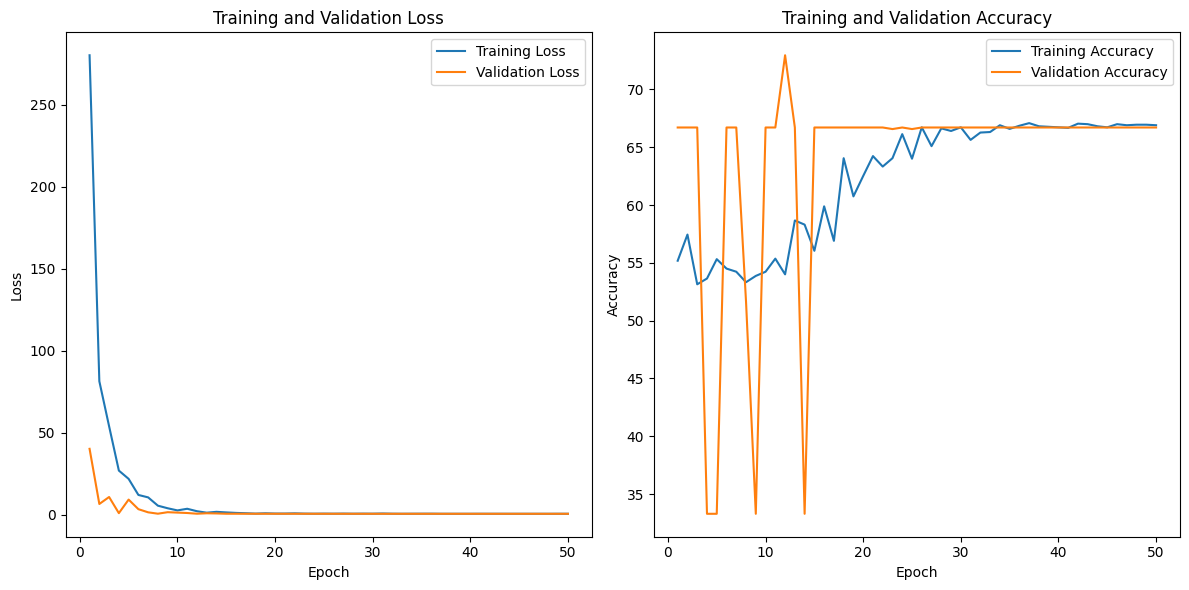

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class SimplifiedNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimplifiedNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),   # First hidden layer
            nn.ReLU(),                   # Activation function
            nn.Dropout(0.3),             # Dropout for regularization
            nn.Linear(64, 32),           # Second hidden layer
            nn.ReLU(),                   # Activation function
            nn.Linear(32, output_size)   # Output layer
        )

    def forward(self, x):
        return self.network(x)

# Convert split data into PyTorch datasets, then into DataLoader for batching
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
validation_data = TensorDataset(torch.FloatTensor(X_validation), torch.LongTensor(y_validation))

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_data, batch_size=batch_size, shuffle=False)

input_size = features.shape[1]  # Number of features
output_size = 2  # binary classification (e.g., NREM and WAKE)

model = ComplexNN(input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate

epochs = 50
train_losses, validation_losses, train_accuracies, validation_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_predictions / total_predictions * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    validation_loss = validation_loss / len(validation_loader.dataset)
    validation_accuracy = correct / len(validation_loader.dataset) * 100
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {validation_accuracy:.2f}%')


def plot_metrics(train_losses, validation_losses, train_accuracies, validation_accuracies):
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, validation_losses, train_accuracies, validation_accuracies)